In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Overview

## 문제 정의
> 1912년 4월 15일 타이타닉호 침몰
> 총 2224명 중 1502명이 사망한 사건
- 문제 해결 목표: 생존-사망 데이터를 분석하여 생존 가능성이 더 높은 사람의 유형을 예측하는 모델 구축

## train.csv 데이터 셋 설명
- 탑승객의 일부(891명)에 대한 승객 정보
- columns
    - PassengerId: 승객 고유번호(int)
    - Survived: 생존 여부(int, 0: 사망, 1: 생존)
    - Pclass: 탑승권 등급(int, 1: 1st, 2: 2nd, 3: 3rd)
    - Name: 승객 이름(object(str))
    - Sex: 승객 성별(object(str))
    - Age: 승객 나이(float, 1보다 작으면 분수, 추정된 나이는 xx.5의 형태)
    - SibSp: 동승자 수-형제자매&부부(int, 단 정부나 약혼자는 제외) 
    - Parch: 동승자 수-부모자식(int, 단 유모와만 탄 아이는 0)
    - Ticket: 탑승권 번호(object(str))
    - Fare: 여객 요금(float)
    - Cabin: 선실 번호(object(str))
    - Embarked: 승선 항구(object(str), C: Cherbourg, Q: Queenstown, S: Southampton)

In [2]:
# 라이브러리 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Check Data

In [3]:
# 데이터 로드
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_df.isnull().sum()/len(train_df)*100 # Null 비율

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
test_df.isnull().sum()/len(test_df)*100 # Null 비율

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

# EDA

## 데이터 형태 파악
- train_df와 test_df의 차이: Survived 컬럼 유무, train_df는 지도학습을 위해 Survived 정보 있고, test_df는 예측을 위해 Survived 컬럼 없음<br/>
&rarr; target 변수: Survived
- train_df Null coloumns: 나이, 선실, 승선 항구
- test_df Null columns: 나이, 여객 요금, 선실

In [10]:
train_df.describe() # data type이 수치형인 변수들의 통계치

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [12]:
train_df.describe(include=[object])  # object 타입 변수들의 통계치

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [13]:
test_df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


## Categorical 변수들 생존-사망 시각화
- Survived: target, 종속 변수, 0 or 1 categorical
- Pclass: 독립변수, 1 or 2 or 3 categorical
- Sex: 독립변수, male or female categorical
- Embarked: 독립변수, C or Q or S categorical
<br/><br/>
1. Survived 개수 -> 불균형 데이터 확인  
2. 독립변수에 따른 Survived 개수 -> 데이터 분포 확인

,count
Survived,
0,549
1,342


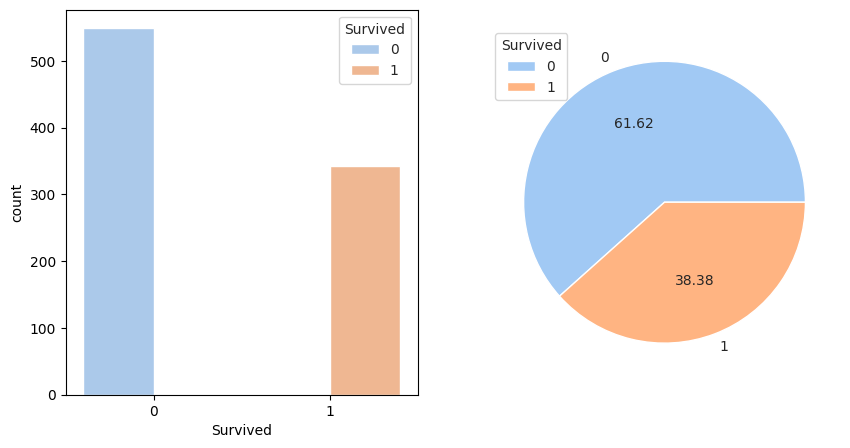

In [14]:
plt.figure(figsize=(10,5))
colors = sns.color_palette('pastel')

plt.subplot(1,2,1)
sns.set_style('whitegrid')
sns.countplot(train_df,x='Survived', hue = 'Survived', palette = colors)

plt.subplot(1,2,2)
plt.pie(train_df['Survived'].value_counts().values, labels = [0, 1], colors = colors, autopct = '%.2f' )
plt.legend(title='Survived')

pd.DataFrame(train_df['Survived'].value_counts())

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<Figure size 800x400 with 0 Axes>

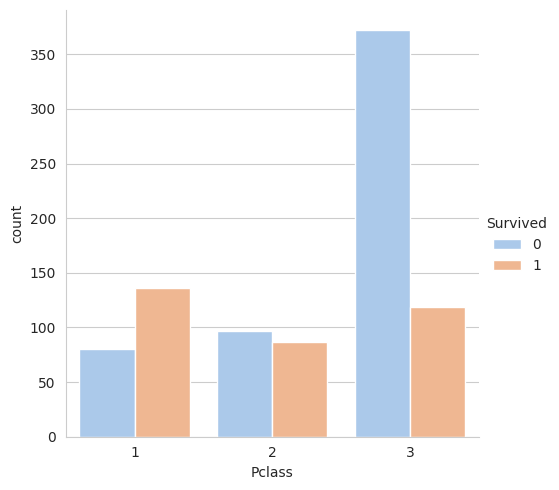

In [15]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Pclass', hue = 'Survived', palette = 'pastel', kind = 'count')

train_df[['Pclass','Survived']].groupby('Pclass').mean()

,Survived
Sex,
female,0.742038
male,0.188908


<Figure size 800x400 with 0 Axes>

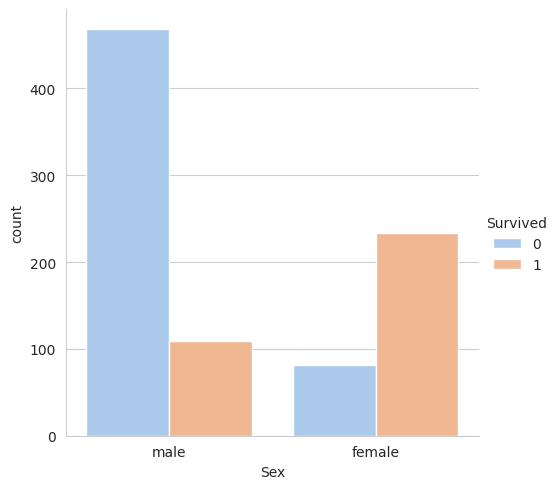

In [16]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Sex', hue = 'Survived', palette = 'pastel', kind = 'count')
train_df[['Sex','Survived']].groupby('Sex').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


<Figure size 800x400 with 0 Axes>

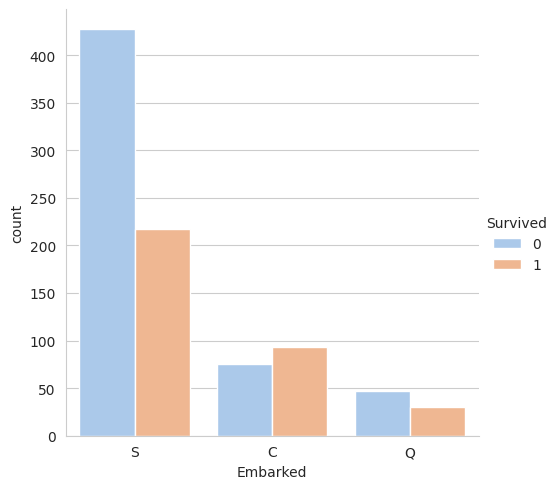

In [17]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Embarked', hue = 'Survived', palette = 'pastel', kind = 'count')

train_df[['Embarked','Survived']].groupby('Embarked').mean()

- Survived  
   : 생존(38.38%) < 사망(61.62%), 데이터 불균형 해소 과정(과적합 해결)은 이후 score 개선 단계에서 생각<br/><br/>
- Pclass  
   : 1등급 생존률 62.96%, 2등급 생존률 47.28%, 3등급 생존률 24.28%,  3등급 탑승권의 사망자가 눈에 띄게 많으므로 해석할 필요가 있어보임, 변수 채택<br/><br/>
- Sex  
   : 성별에 따라 생존-사망의 패턴이 반대(여 생존률 74.20%, 남 생존률 18.89%)로 나타나므로 해석할 필요가 있어보임, 변수 채택<br/><br/>
- Embarked  
   : 셰르부르C 생존률 55.34%, 퀸스타운Q 생존률 38.96%, 사우샘프턴S 생존률 33.70%, C에서 승선한 탑승객의 생존-사망 패턴만 다름(근소하나 생존 우의), 해석할 필요가 있어보임, 변수 채택

## 수치형 변수들 생존-사망 시각화

In [18]:
n_train_df = train_df.select_dtypes(include=np.number).iloc[:,[0,3,4,5,6]]
n_train_df.head()

,PassengerId,Age,SibSp,Parch,Fare
0,1,22.0,1,0,7.2500
1,2,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,4,35.0,1,0,53.1000
4,5,35.0,0,0,8.0500


- 이산형: PassengerId, SibSp,Parch
- 연속형: Age, Fare  
- PassengerId &rarr; 이후의 정보라 생존-사망과는 관련 없어보임 &rarr; 변수 제외  
\*참고, 모두 독립변수 
1. Survived가 사망(0)인 경우와 생존(1)인 경우의 각각의 변수 형태 확인
2. 이상치 데이터 확인
3. 시각화: 히스토그램, boxplot 등

<Axes: ylabel='Parch'>

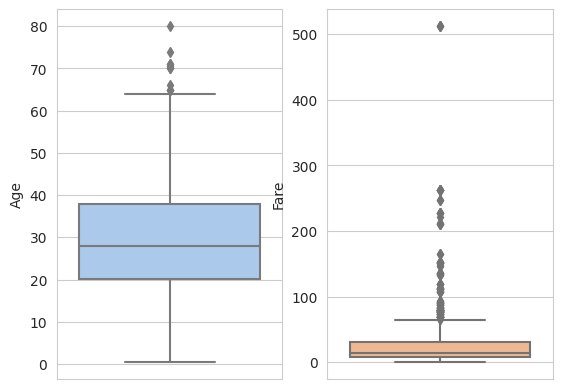

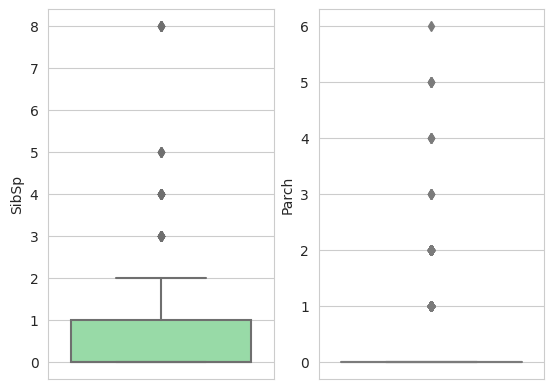

In [19]:
fig1, axes1 = plt.subplots(1,2)

sns.boxplot(y=n_train_df['Age'],color=colors[0],ax=axes1[0])
sns.boxplot(y=n_train_df['Fare'],color=colors[1],ax=axes1[1])

fig2, axes2 = plt.subplots(1,2)

sns.boxplot(y = n_train_df['SibSp'],color=colors[2],ax=axes2[0])
sns.boxplot(y = n_train_df['Parch'],color=colors[3],ax=axes2[1])


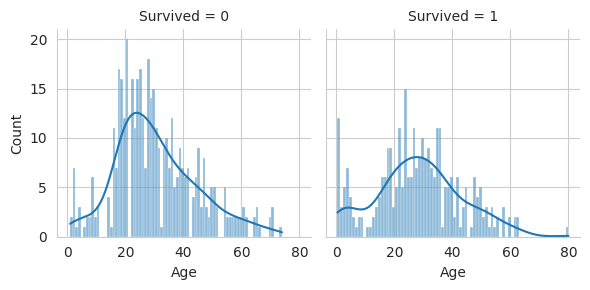

In [20]:
p = sns.FacetGrid(train_df,col = 'Survived',palette=colors)
p = p.map(sns.histplot, 'Age',bins=80,kde=True)

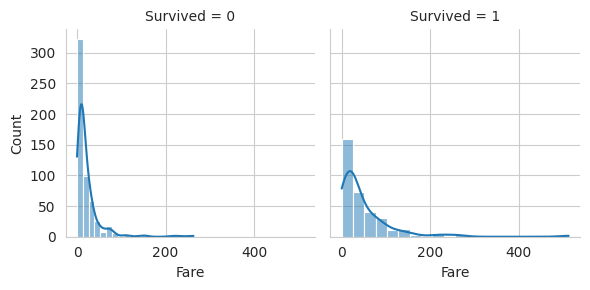

In [21]:
p = sns.FacetGrid(train_df,col = 'Survived',palette=colors)
p = p.map(sns.histplot, 'Fare',bins=20,kde=True)

<Figure size 800x400 with 0 Axes>

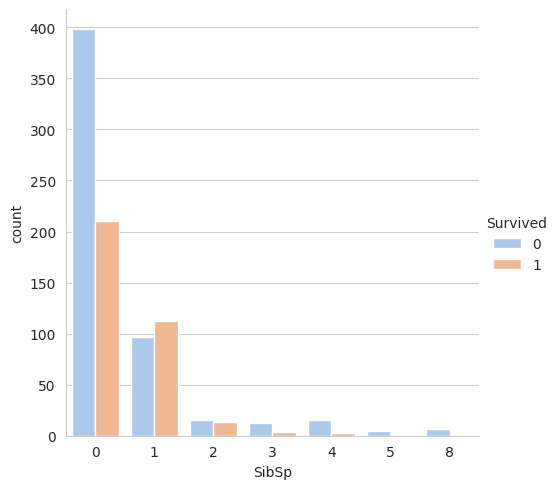

In [22]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='SibSp', hue = 'Survived', palette = colors, kind = 'count')

<Figure size 800x400 with 0 Axes>

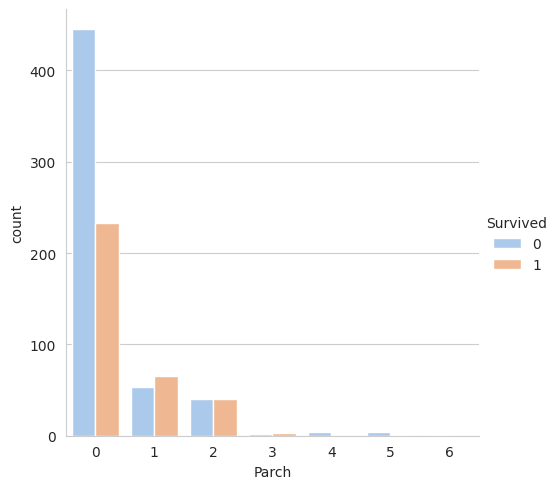

In [23]:
plt.figure(figsize=(8,4))

sns.set_style('whitegrid')
sns.catplot(train_df, x='Parch', hue = 'Survived', palette = colors, kind = 'count')

- 네 독립변수 모두 이상치 존재  
- SibSp와 Parch는 동승자에 대한 정보라는 점에서 공통점 존재, 동승자라는 새로운 변수 생성
- Fare는 Pclass과 함께 비용이라는 공통점이 존재(Pclass의 등급이 높을 수록 비용이 높을 것이라는 생각),   
  Fare를 category로 범주화하여 이상치 해결
- 원래 나이는 이산형 데이터지만, Age 변수는 1살 미만의 아이와 정확한 나이를 모르는 사람은 소수점 이하 자리가 있는 연속형,  
  고령자의 인원이 별로 없어 이상치가 되는 점, 특정 변수값(0)에 분포가 몰려있다는 점을 고려해 연령대 범주화로 해결

## Object(문자형) 변수들
- 데이터 타입이 object였던 변수 중, categorical이 아니어서 시각화하지 못한 변수들  
    : Name, Ticket, Cabin

In [24]:
train_df['Name'].iloc[:11], train_df['Name'].isnull().sum()

(0                               Braund, Mr. Owen Harris
 1     Cumings, Mrs. John Bradley (Florence Briggs Th...
 2                                Heikkinen, Miss. Laina
 3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
 4                              Allen, Mr. William Henry
 5                                      Moran, Mr. James
 6                               McCarthy, Mr. Timothy J
 7                        Palsson, Master. Gosta Leonard
 8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
 9                   Nasser, Mrs. Nicholas (Adele Achem)
 10                      Sandstrom, Miss. Marguerite Rut
 Name: Name, dtype: object,
 0)

In [25]:
train_df['Ticket'].iloc[50:60], train_df['Ticket'].isnull().sum()

(50       3101295
 51    A/4. 39886
 52      PC 17572
 53          2926
 54        113509
 55         19947
 56    C.A. 31026
 57          2697
 58    C.A. 34651
 59       CA 2144
 Name: Ticket, dtype: object,
 0)

In [26]:
train_df[train_df['Cabin'].notnull()]['Cabin'], train_df['Cabin'].isnull().sum()

(1              C85
 3             C123
 6              E46
 10              G6
 11            C103
           ...     
 871            D35
 872    B51 B53 B55
 879            C50
 887            B42
 889           C148
 Name: Cabin, Length: 204, dtype: object,
 687)

- Name: 대부분 '이름, 혼인여부. 성'의 형식, 혼인여부로 성별 판단 가능, 성으로 가족관계 유추 가능, 괄호 안의 정보는 무엇인지 불명확  
    &rarr; 성별에 대한 데이터(Sex)와 가족 관계(동승자)(SibSp,Parch)에 대한 데이터가 모두 존재하므로 이번 분석에서는 Name 변수 제외
- Ticket: 형식이 일관되지 않음(알파벳+숫자와 숫자 형식이 혼재), 탑승권은 탑승 등급(Pclass)와 여객 요금(Fare)의 정보를 담고 있을 것이라 생각, 이번 분석에서는 변수 제외
- Cabin: 형식은 '알파벳+숫자'로 일관되나 값이 1개가 아닌 데이터(index 872)가 존재, 또한 결측치의 비율이 약 77%로 결측치 처리가 어려워 보임, 변수 제외

# 전처리(Preprocessing)

## 필요한 전처리 내용
- 결측치 처리
    - Age, Embarked, Fare(test에만 있음->모델 제출 시에는 결측치 제거 함수 필요할 듯)
<br/><br/>
- 라벨링
    - Sex, Embarked
<br/><br/>
- 이상치 처리
    - Age, Fare, SibSp, Parch

#### 범주형 변수 Embarked의 결측치 처리: 최빈값

In [27]:
train_df['Embarked'].value_counts(), train_df['Embarked'].isnull().sum()

(Embarked
 S    644
 C    168
 Q     77
 Name: count, dtype: int64,
 2)

<Axes: xlabel='Embarked', ylabel='count'>

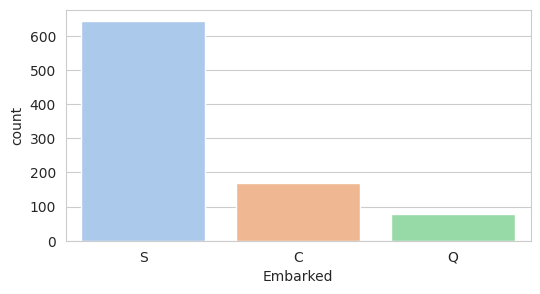

In [28]:
fig = plt.figure(figsize=(6,3))
sns.countplot(x = train_df['Embarked'],palette=colors)

In [29]:
# 결측치를 갖는 데이터 2개는 최빈값인 S에 할당
train_df['Embarked'] = train_df['Embarked'].fillna('S')
train_df['Embarked'].isnull().sum()

0

#### 라벨링

In [30]:
# {'male':0, 'female':1}
train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})

In [31]:
# {'C':0, 'S':1, 'Q':2}
train_df['Embarked'] = train_df['Embarked'].map({'C':0, 'S':1, 'Q':2})

#### 수치형 변수 Age의 결측치 처리
- 결측치의 분류
    - MCAR, MAR, MNAR
    - Age 변수와 다른 변수들의 상관관계 확인


<Axes: >

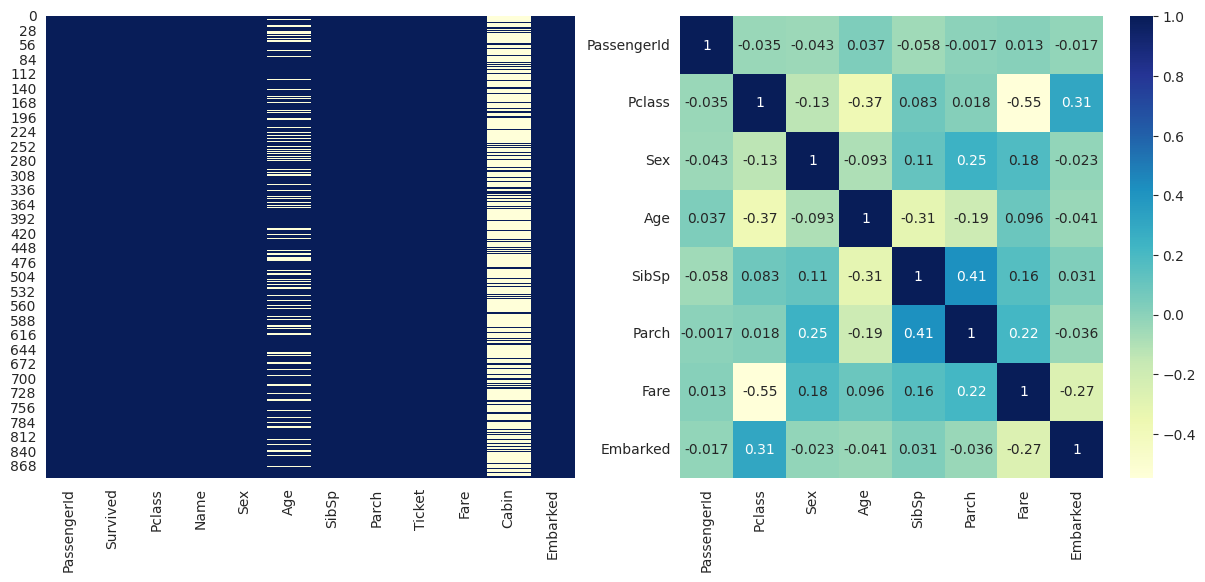

In [32]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15,6)
sns.heatmap(train_df.isnull(), cbar=False, cmap='YlGnBu_r',ax=axes[0])
sns.heatmap(train_df.drop(['Survived','Cabin','Name','Ticket'],axis = 1).corr(), annot=True, cmap='YlGnBu', ax= axes[1])

- 왼쪽 히트맵: 결측치들의 분포 위치 시각화
- 오른쪽 히트맵: 변수들 간의 상관관계 시각화
<br/><br/>
- Age 변수의 결측값의 분포를 보면 특정한 패턴 없이 무작위로 발생했음을 알 수 있음 -> MCAR, MAR
- Age 변수와 다른 변수들 간의 상관관계를 보면 대부분 0에 가까움.
- Pclass와 SibSp는 다른 변수들에 비해 상대적으로 -1에 가까움

In [33]:
# Sex-Age
ma = train_df[train_df['Sex'] == 0]['Age'].dropna()  # male-Age
fa = train_df[train_df['Sex'] == 1]['Age'].dropna()  # female-Age

# 독립성 검정: 데이터셋 크기 달라서 공분산 계산 X, 임의로 잘라도 되나?

# 정규성 검정
s_s, s_p = stats.shapiro(ma)
if s_p > 0.05:
    print(s_p, '정규성 가정')
else:
    print(s_p, '정규성 없음, 맨휘트니')

s_s, s_p = stats.shapiro(fa)
if s_p > 0.05:
    print(s_p, '정규성 가정')
else:
    print(s_p, '정규성 없음, 맨휘트니')

# 등분산성 검정
l_s, l_p = stats.levene(ma,fa)
if l_p > 0.05:
    print(l_p, '등분산성 가정')
else:
    print(l_p, '등분산성 없음, 웰치 방법')

'''
맨 휘트니 유
H0 남녀 나이 중위수 차이 없음
H1 남녀 나이 중위수 차이 있음
'''
m, p = stats.mannwhitneyu(ma,fa)

print(f'm_statisctic: {m}\np_value: {p}')

4.5733966658190184e-07 정규성 없음, 맨휘트니
0.007052930071949959 정규성 없음, 맨휘트니
0.9712114169671999 등분산성 가정
m_statisctic: 65020.5
p_value: 0.026087746884279634


In [34]:
# Pclass-Age
a1 = train_df[train_df['Pclass'] == 1]['Age'].dropna() # first-Age
a2 = train_df[train_df['Pclass'] == 2]['Age'].dropna() # second-Age
a3 = train_df[train_df['Pclass'] == 3]['Age'].dropna() # Third-Age

# 독립성 검정

# 정규성 검정
s_s, s_p = stats.shapiro(a1)
if s_p > 0.05:
    print(s_p, '정규성 있음')
else:
    print(s_p, '정규성 없음, 크루스칼 왈리스')

s_s, s_p = stats.shapiro(a2)
if s_p > 0.05:
    print(s_p, '정규성 있음')
else:
    print(s_p, '정규성 없음, 크루스칼 왈리스')

s_s, s_p = stats.shapiro(a3)
if s_p > 0.05:
    print(s_p, '정규성 있음')
else:
    print(s_p, '정규성 없음, 크루스칼 왈리스')


# 등분산성
l_s, l_p = stats.levene(a1,a2,a3)
if l_p > 0.05:
    print(l_p, '등분산성 가정')
else:
    print(l_p, '등분산성 없음')

'''
Kruskal-Wallis H
H0 각 등급의 나이 중앙값 차이 없음
H1 각 등급의 나이 중앙값 차이 있음
'''

k, p = stats.kruskal(a1,a2,a3)

print(f'k_statisctic: {k}\np_value: {p}')

0.3643055558204651 정규성 있음
0.005649181082844734 정규성 없음, 크루스칼 왈리스
4.183878445473965e-06 정규성 없음, 크루스칼 왈리스
0.0037869205998203245 등분산성 없음
k_statisctic: 95.99479230295296
p_value: 1.4288798296552103e-21


In [35]:
# Age의 결측치는 Pclass별 Age의 중앙값으로 처리
train_df[['Pclass','Age']].groupby('Pclass').median()

train_df[['Pclass','Age']] = train_df[['Pclass','Age']].groupby('Pclass').apply(lambda x:x.fillna(x.mean())).droplevel(level =0,axis=0).sort_index()

train_df['Age'].isnull().sum()

0

#### 이상치 처리

<Axes: xlabel='Age', ylabel='Count'>

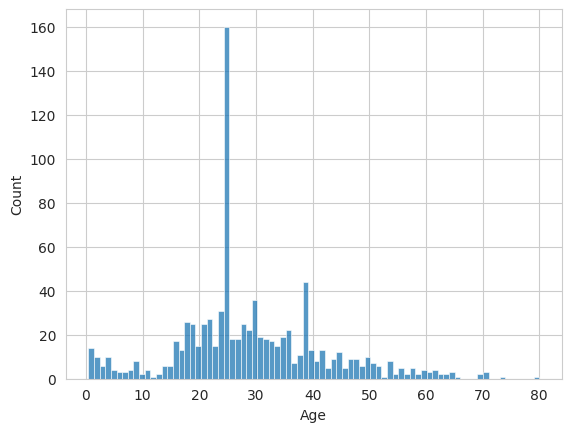

In [36]:
# Age histogram 보기
sns.histplot(train_df['Age'], bins = 80)

<Axes: xlabel='Age', ylabel='Count'>

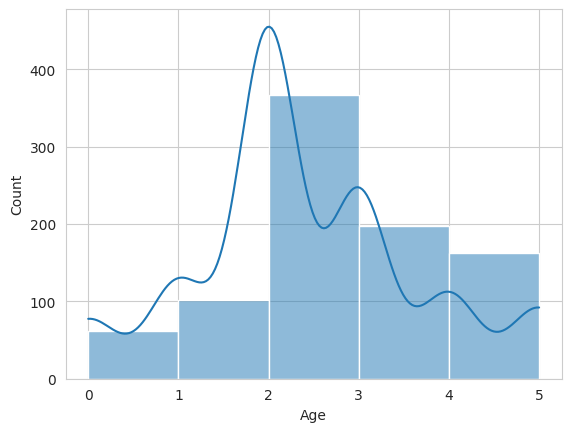

In [37]:
# 연령대 나누기: {0-10:0, 10-20:1, 20-30:2, 30-40:3, 40-50:4, 50-:5}
train_df['Age'] = train_df['Age'].apply(lambda x: x//10 if x < 50 else 5)
sns.histplot(train_df['Age'], bins = 5,kde=True)

<Axes: ylabel='Fare'>

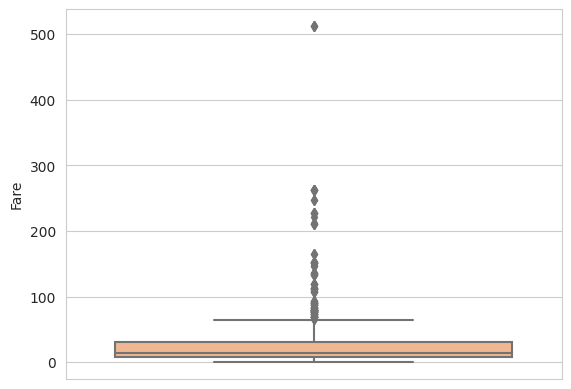

In [38]:
# Fare 이상치 확인
sns.boxplot(y=n_train_df['Fare'],color=colors[1])

<Axes: ylabel='Fare'>

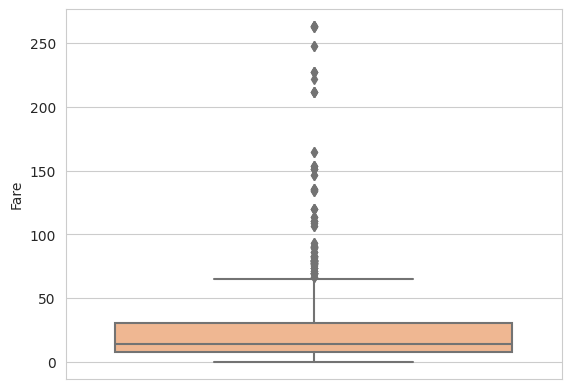

In [39]:
# 유독 눈에 띄는 데이터 제외 후 다시 이상치 확인
a = train_df[train_df['Fare'] != max(train_df['Fare'].values)]
sns.boxplot(y=a['Fare'],color=colors[1])
# 결과: 여전히 이상치 많음 -> 범주화 시도

<Axes: ylabel='Fare'>

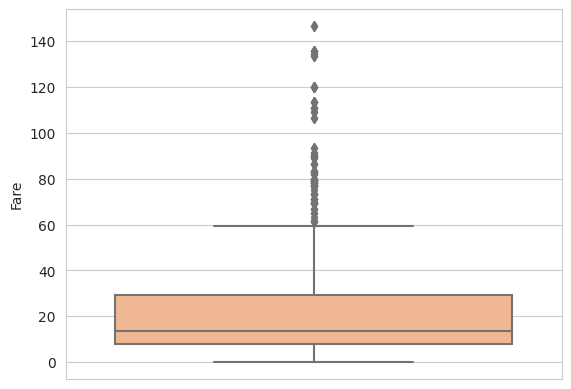

In [40]:
# 유독 눈에 띄는 데이터 제외 후 다시 이상치 확인
a = train_df[train_df['Fare'] < 150]
sns.boxplot(y=a['Fare'],color=colors[1])
# 결과: 여전히 이상치 많음 -> 범주화 시도

<Axes: xlabel='Fare', ylabel='Density'>

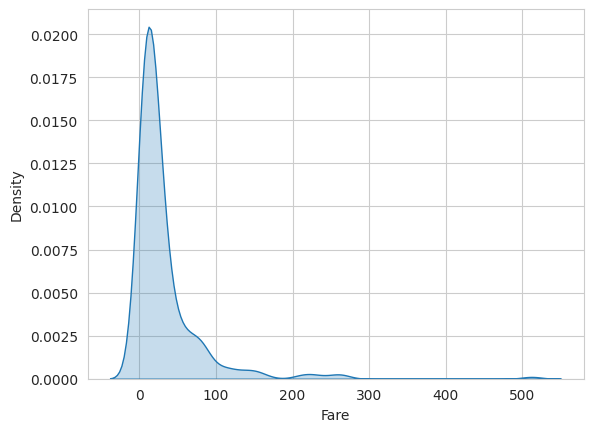

In [41]:
sns.kdeplot(train_df['Fare'],fill=True)

In [42]:
# 분포가 몰린 관계로 일정 비율로 Fare 범주화 (요금과 관계있어 보이는 Pclass가 등급이 3개이므로 3분할) {'low':0, 'mid':1, 'high':2}
train_df['Fare'] = pd.qcut(train_df['Fare'],3,labels=[0,1,2])

<Axes: xlabel='Parch', ylabel='Count'>

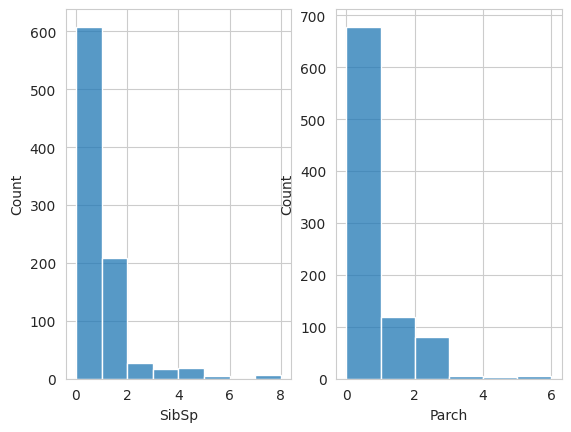

In [43]:
# SibSp와 Parch histogram 보기
fig, axes = plt.subplots(1,2)

sns.histplot(train_df['SibSp'], bins = 8,ax = axes[0])

sns.histplot(train_df['Parch'], bins = 6, ax = axes[1])

# EDA 결과
- Survived: 범주형 종속변수 
- Pclass, Sex, Age, Fare, Embarked: 범주형 독립변수, 서열 존재(Pclass,Age,Fare)
- SibSp, Parch: 이산형 독립변수

In [44]:
train_df = train_df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,2.0,1,0,0,1
1,1,1,1,3.0,1,0,2,0
2,1,3,1,2.0,0,0,0,1
3,1,1,1,3.0,1,0,2,1
4,0,3,0,3.0,0,0,0,1


# 분류기 학습
- 종속변수 Survived: 지도학습
- 지도학습 중 분류 수행 알고리즘
    - 나이브 베이즈(Naive Bayes):  
        서로 독립인 feature(독립변수) &rarr;베이즈정리&rarr;Label 분류
    - K-NN:  
        K개의 가장 가까운 이웃&rarr;Label 분류, 비모수, 이상치에 덜 민감
    - 의사결정나무:  
        조건에 따른 대상 분류, 이상치 덜 민감, 과적합 위험
    - 랜덤포레스트:  
        앙상블, 배깅, 여러 DT 학습&rarr;결과 결합, DT의 과적합 방지, 이상치 덜 민감
    - 로지스틱 회귀:  
        선형 방정식, 이상치 민감
    - SVM(linear,kernel):  
        거리 가장 먼 초평면 선택 분리, 마진 최대화, 
    - 그라디언트 부스팅(GBM):  
        앙상블, 부스팅, 잔차 학습&rarr;가중치&rarr;잔차 감소 반복
    - xg 부스트:
        앙상블, 부스팅, GBM 성능 및 속도 개선, 과적합 방지
    - 라이트 GBM:  
        앙상블, 부스팅, 가지치기, 메모리 적음, 과적합 위험
    - 캣부스트:  
        앙상블, 부스팅, 범주형에 최적화, 연속형 변수&rarr;속도 저하 위험

titanic train data는 데이터 수가 많지 않고, 변수도 많지 않음, 이상치 처리를 위해 범주화 가공을 많이 함  
따라서 이번 분류에서는 랜덤포레스트, xgBoost, catBoost 활용 예정

In [45]:
# RandomForest
